In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from Constants.constants import TOPICS, TOPICS_MAP, DOCUMENTS_PATH

In [2]:
def create_dataset(topics):
    data = {'hash':[],'topic': [], 'text': []}
    for topic in topics:
        for file in os.listdir(os.path.join(DOCUMENTS_PATH,topic)):
            with open(os.path.join(DOCUMENTS_PATH, topic, file), "r", encoding="utf-8") as f:
                text = f.read()
                data['hash'].append(file)
                data['topic'].append(topic)
                data['text'].append(text)
    return pd.DataFrame(data)

data = create_dataset(TOPICS)
data

,hash,topic,text
0,0447d5ebcb5fb4c3c35428319d035a2b43f53c8561d683...,Astronomy,unidentified rocket displayed military parade ...
1,070c9fd24e43ba164f3a68dd8c976a57461fceb038a43d...,Astronomy,cosmic countdown begun director james gunn ’ `...
2,09559783f5ee1852885289ba8fd16625284625dd41875e...,Astronomy,planetary society taking stand nasa 's stalled...
3,09d01585d21facc6f893ec9c64a6d79ffc107be243f10d...,Astronomy,may helpful receive news updates notifications...
4,0a3d8dfb0821ff1ed7ad6fd00ad318c667f9300b37ea71...,Astronomy,spacex falcon 9 rocket used first stage launch...
...,...,...,...
457,eea2c24632f92505ff2ca5943b32cbbecc275108b6d161...,Economy,10-yr bondnasdaqvolatilityftsenikkei 225cad/eu...
458,eef2eb784de051b634f8ca91e4fb907b8b35109488e277...,Economy,"meta lays tech teams , battering employee mora..."
459,f0b07ab98c445e62cfbed189b95c7414c45c1c28256329...,Economy,spike oil prices surprise opec+ production cut...
460,f5588a9b6dd95855a3150f9779f7c229c02a42ce688995...,Economy,u.s. stocks open lower investors receive anoth...


In [3]:
def preprocess(data,topics_map):
    tokenizer = RegexpTokenizer(r'\w+')
    data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['text'] = data['text'].apply(lambda x: ' '.join(x))
    data['label'] = data['topic'].map(topics_map)
    X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess(data,TOPICS_MAP)
X_train

200    data surveillance workgroupdata surveillance w...
213    third party tools sitescdc content gets publis...
264    new funding announced evaluate exposure enviro...
313    nikkei 225cad eurgas prices increase nj around...
409    dow jones networkintraday data provided factse...
                             ...                        
323    nikkei 225cad eurdeadly storm whips tornadoes ...
192    correction process policiescmaj news team corr...
117    japanese company restarting effort create arti...
47     purchase links site may earn affiliate commiss...
172    hearing lots achoos little one grown ups ones ...
Name: text, Length: 369, dtype: object

In [4]:
def create_tf_idf(X_train,X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf
X_train_tfidf, X_test_tfidf = create_tf_idf(X_train,X_test)
X_train_tfidf

<369x21360 sparse matrix of type '<class 'numpy.float64'>'
	with 113706 stored elements in Compressed Sparse Row format>

In [5]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

def cross_validate_and_train(model,X_train_tfidf,y_train):
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score,average='macro'),
           'recall': make_scorer(recall_score, average='macro'),
           'f1_score': make_scorer(f1_score, average='macro')}
    K_folds = 5
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=K_folds, scoring=scoring, return_estimator=True)
    for i in range(K_folds):
        print(f"Fold: {i+1}")
        print(f"Accuracy: {cv_results['test_accuracy'][i]}")
        print(f"Precision: {cv_results['test_precision'][i]}")
        print(f"Recall: {cv_results['test_recall'][i]}")
        print(f"F1 Score: {cv_results['test_f1_score'][i]}")
        print("\n")
    print("Mean Metrics")
    print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
    print(f"Mean Precision: {np.mean(cv_results['test_precision'])}")
    print(f"Mean Recall: {np.mean(cv_results['test_recall'])}")
    print(f"Mean F1 Score: {np.mean(cv_results['test_f1_score'])}")

    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    best_metric = max(mean_scores, key=mean_scores.get)
    best_estimator_index= np.argmax(cv_results['test_'+best_metric])
    best_estimator = cv_results['estimator'][best_estimator_index]
    print(f"Best Estimator: {best_estimator_index}")
    return best_estimator

In [6]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, RocCurveDisplay
def test_model(model,X_test_tfidf,y_test, plot=False):
    print("Test Metrics")
    y_pred = model.predict(X_test_tfidf)
    #Test to see if predict_proba works
    _ = model.predict_proba(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    if plot:
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
        plt.show()
    return report

Model: SVC
Fold: 1
Accuracy: 0.9594594594594594
Precision: 0.9619753086419753
Recall: 0.9588888888888888
F1 Score: 0.9593534002229654


Fold: 2
Accuracy: 0.9864864864864865
Precision: 0.9871794871794872
Recall: 0.9861111111111112
F1 Score: 0.9863718537060214


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 5
Accuracy: 0.9726027397260274
Precision: 0.9727777777777779
Recall: 0.9727777777777779
F1 Score: 0.9727777777777779


Mean Metrics
Mean Accuracy: 0.9837097371343948
Mean Precision: 0.9843865147198481
Mean Recall: 0.9835555555555555
Mean F1 Score: 0.9837006063413529
Best Estimator: 2
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        33

    accuracy                           1.00        93
   macro avg       1.00  

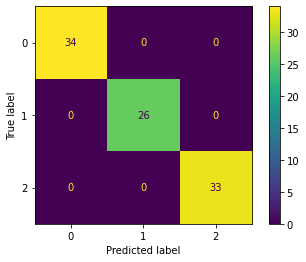



Model: KNeighborsClassifier
Fold: 1
Accuracy: 0.972972972972973
Precision: 0.9733333333333333
Recall: 0.9733333333333333
F1 Score: 0.9733333333333333


Fold: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 3
Accuracy: 0.9864864864864865
Precision: 0.9871794871794872
Recall: 0.9861111111111112
F1 Score: 0.9863718537060214


Fold: 4
Accuracy: 0.9864864864864865
Precision: 0.9866666666666667
Recall: 0.9861111111111112
F1 Score: 0.9861050803300043


Fold: 5
Accuracy: 0.9726027397260274
Precision: 0.9727777777777779
Recall: 0.9727777777777779
F1 Score: 0.9727777777777779


Mean Metrics
Mean Accuracy: 0.9837097371343948
Mean Precision: 0.9839914529914531
Mean Recall: 0.9836666666666666
Mean F1 Score: 0.9837176090294273
Best Estimator: 1
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        33

 

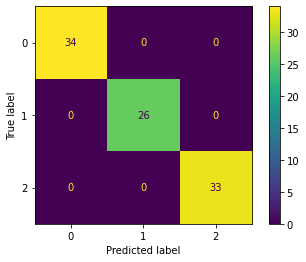



Model: DecisionTreeClassifier
Fold: 1
Accuracy: 0.8783783783783784
Precision: 0.8799651100375737
Recall: 0.8783333333333333
F1 Score: 0.8782051282051282


Fold: 2
Accuracy: 0.918918918918919
Precision: 0.9242610837438422
Recall: 0.9177777777777778
F1 Score: 0.9178634416729655


Fold: 3
Accuracy: 0.918918918918919
Precision: 0.9201571268237935
Recall: 0.9188888888888888
F1 Score: 0.9177048888295088


Fold: 4
Accuracy: 0.8783783783783784
Precision: 0.87995337995338
Recall: 0.8771367521367521
F1 Score: 0.8775473801560759


Fold: 5
Accuracy: 0.8493150684931506
Precision: 0.8501486436269046
Recall: 0.8488888888888889
F1 Score: 0.8488232739904472


Mean Metrics
Mean Accuracy: 0.888781932617549
Mean Precision: 0.8908970688370988
Mean Recall: 0.8882051282051282
Mean F1 Score: 0.888028822570825
Best Estimator: 1
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        34
           1       0.88      0.81      0.84        26

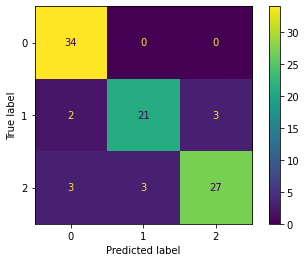



Model: LogisticRegression
Fold: 1
Accuracy: 0.9864864864864865
Precision: 0.9871794871794872
Recall: 0.9866666666666667
F1 Score: 0.9866613311991462


Fold: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 5
Accuracy: 0.9726027397260274
Precision: 0.9727777777777779
Recall: 0.9727777777777779
F1 Score: 0.9727777777777779


Mean Metrics
Mean Accuracy: 0.9918178452425028
Mean Precision: 0.9919914529914531
Mean Recall: 0.9918888888888888
Mean F1 Score: 0.9918878217953848
Best Estimator: 1
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        33

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg  

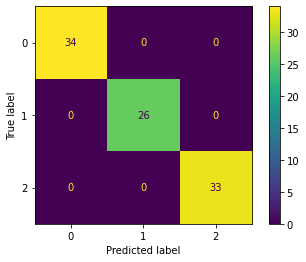



Model: GaussianNB
Fold: 1
Accuracy: 0.9459459459459459
Precision: 0.9487179487179488
Recall: 0.9455555555555555
F1 Score: 0.9462915601023019


Fold: 2
Accuracy: 0.918918918918919
Precision: 0.9292929292929294
Recall: 0.9183333333333333
F1 Score: 0.9194348667059121


Fold: 3
Accuracy: 0.9324324324324325
Precision: 0.9331995540691193
Recall: 0.9322222222222223
F1 Score: 0.9324488944513977


Fold: 4
Accuracy: 0.9594594594594594
Precision: 0.9605128205128205
Recall: 0.9594017094017094
F1 Score: 0.9596791253326208


Fold: 5
Accuracy: 0.9178082191780822
Precision: 0.9173892773892773
Recall: 0.9172222222222223
F1 Score: 0.9165057327278738


Mean Metrics
Mean Accuracy: 0.9349129951869678
Mean Precision: 0.937822505996419
Mean Recall: 0.9345470085470087
Mean F1 Score: 0.9348720358640212
Best Estimator: 3
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        34
           1       1.00      0.96      0.98        26
       

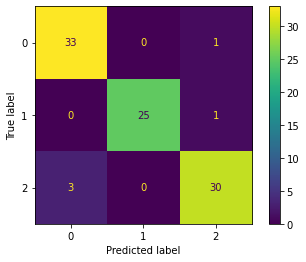

In [7]:
def train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test):
    models = [SVC(probability=True),KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression(),GaussianNB()]
    reports = {}
    for model in models:
        print(f"Model: {model.__class__.__name__}")
        if model.__class__.__name__ == "GaussianNB":
            X_train_tfidf = X_train_tfidf.toarray()
            X_test_tfidf = X_test_tfidf.toarray()
        best_estimator = cross_validate_and_train(model,X_train_tfidf,y_train)
        print(best_estimator.classes_)
        report = test_model(best_estimator,X_test_tfidf,y_test,plot=True)
        reports[model.__class__.__name__] = [best_estimator,report]
        print("\n")
    return reports
reports = train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test)

In [8]:
def choose_best_model(reports):
    #Choose best model based on highest accuracy, precision, recall and f1 score
    best_model = None
    best_score = 0
    model_name = None
    for model in reports:
        report = reports[model][1]
        score = report['accuracy'] + report['macro avg']['precision'] + report['macro avg']['recall'] + report['macro avg']['f1-score']
        if score > best_score:
            best_score = score
            best_model = reports[model][0]
            model_name = model
    return model_name, best_model
model_name, best_model = choose_best_model(reports)
print(f"Best Model: {model_name}")

Best Model: SVC


{'n_neighbors': 7}
0.9864124398370974
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        33

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



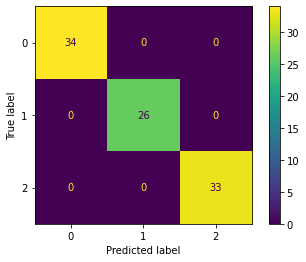

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 33},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 93},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 93}}

In [12]:
def knn_grid_search(X_train_tfidf, y_train):
    param_grid = {'n_neighbors': [3, 5, 7, 9]}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_tfidf, y_train)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search.best_estimator_
knn_best_estimator = knn_grid_search(X_train_tfidf, y_train)
test_model(knn_best_estimator,X_test_tfidf,y_test,plot=True)

In [10]:
probs = best_model.predict_proba(X_test_tfidf)
for prob in probs:
    print(prob)

[9.99819698e-01 2.16055555e-05 1.58696936e-04]
[0.97601971 0.00808975 0.01589054]
[0.99770591 0.0010635  0.0012306 ]
[0.70583912 0.16667485 0.12748603]
[0.00266124 0.99323044 0.00410832]
[3.00392820e-11 2.51416112e-11 1.00000000e+00]
[3.00392820e-11 2.51416112e-11 1.00000000e+00]
[0.58832465 0.26959278 0.14208257]
[0.9943046  0.00382418 0.00187122]
[3.00392820e-11 2.51416112e-11 1.00000000e+00]
[9.98970105e-01 5.56270390e-04 4.73624185e-04]
[9.99980092e-01 8.07956848e-06 1.18284415e-05]
[0.00414288 0.00175557 0.99410155]
[3.00392820e-11 2.51416112e-11 1.00000000e+00]
[9.98349012e-01 8.78312739e-04 7.72675348e-04]
[1.05739262e-06 9.99605957e-01 3.92985648e-04]
[4.53206911e-08 3.19612981e-08 9.99999923e-01]
[0.95952994 0.01423765 0.02623242]
[2.98860481e-07 9.99870770e-01 1.28931202e-04]
[0.00266592 0.00249578 0.99483829]
[2.99500706e-09 9.99984945e-01 1.50519557e-05]
[3.57236704e-08 9.99914643e-01 8.53211878e-05]
[0.01323265 0.97575438 0.01101297]
[0.54161595 0.16526935 0.29311469]
[3.0

In [11]:
# def save_model(model):
#     joblib.dump(model, "classifier.joblib")